# AllDifferent

In this notebook, we take a quick look onto the AllDifferent constraint on the example of the graph coloring problem.
We especially analyze the effect of the automatic AllDifferent inference.
If you are using `!=` instead of `AllDifferent`, CP-SAT will automatically try to find large cliques of variables that are all different and add them as AllDifferent constraints.
This is significantly faster than adding non-optimized AllDifferent constraints manually.
This optimization gets disabled as soon as a single AllDifferent constraint is added manually, and we can see that the solver is significantly slower.
Thus, only use `AllDifferent` if you do it properly on large sets of variables.

# Graph Coloring Problem

The **Graph Coloring Problem** is a classic combinatorial optimization problem in computer science and graph theory. It involves assigning colors to the vertices of an undirected graph in such a way that no two adjacent vertices share the same color while using the fewest number of colors possible.

## Problem Statement

Given an undirected graph G = (V, E), where V represents the set of vertices and E represents the set of edges, the objective is to find a coloring function C: V -> {1, 2, ..., k} such that:

1. For each vertex v ∈ V, C(v) is an integer representing the color assigned to vertex v.
2. For all edges (u, v) ∈ E, C(u) ≠ C(v), meaning adjacent vertices must have different colors.

## Objective

Minimize the number of colors (k) used in the coloring while satisfying the above conditions. This minimum value of k is referred to as the **chromatic number** of the graph, denoted as χ(G).

## Applications

Graph coloring problems have numerous practical applications in various domains, including:

- Scheduling of tasks with resource constraints.
- Register allocation in compiler optimization.
- Frequency assignment in wireless communication.
- Timetabling in educational institutions.
- Map coloring in cartography.

## Complexity

The Graph Coloring Problem is NP-hard, which means that finding the optimal coloring in the fewest colors is computationally challenging. It falls within the broader class of NP-hard problems and is used as a benchmark for testing the efficiency of algorithms and heuristics.

Researchers in computer science and operations research continue to develop algorithms and approaches to solve instances of the Graph Coloring Problem efficiently and find approximate solutions for large graphs.

For more details and formal algorithms related to the Graph Coloring Problem, please refer to academic literature and research papers in the field of combinatorial optimization and graph theory.


In [1]:
import networkx as nx
from ortools.sat.python import cp_model


def solve_coloring(
    g: nx.Graph,
    use_all_different: bool,
    disable_infer_diff: bool = False,
    add_single_all_different: bool = False,
) -> int:
    """
    Solves the graph coloring problem for the given graph.
    :param g: the graph to color
    :param use_all_different: whether to use the all_different constraint or != constraint
    :param disable_infer_diff: whether to disable the all_different constraint inference for !=
    :param add_single_all_different: whether to add a single all_different constraint
    """
    model = cp_model.CpModel()
    # specify valid coloring
    x = [model.NewIntVar(0, g.degree[v] - 1, f"v{v}") for v in g.nodes()]
    for v, w in g.edges():
        if use_all_different:
            model.AddAllDifferent([x[v], x[w]])
        else:
            model.Add(x[v] != x[w])
    if add_single_all_different:
        # adding a single all_different will disable the inference of all_different
        # for the != constraint and drastically increase the runtime
        v, w = next(iter(g.edges()))
        model.AddAllDifferent([x[v], x[w]])
    # minimize the maximum color
    max_x = model.NewIntVar(0, max(g.degree[v] for v in g.nodes()), "xc")
    model.AddMaxEquality(max_x, x)
    model.Minimize(max_x)
    # set up solver
    solver = cp_model.CpSolver()
    if disable_infer_diff:
        solver.parameters.infer_all_diffs = False
    solver.parameters.max_time_in_seconds = 300
    # solver.parameters.log_search_progress = True
    # solver.log_callback = print
    # solver
    status = solver.Solve(model)
    return status

In [2]:
g = nx.connected_caveman_graph(35, 35)

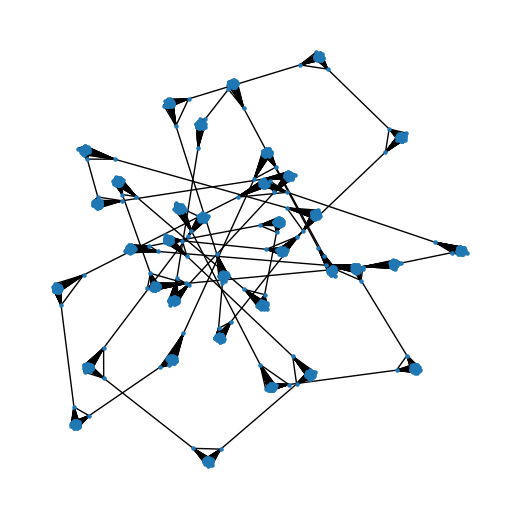

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

nx.draw(g, with_labels=False, pos=nx.spring_layout(g), node_size=5)
plt.show()

In [4]:
# solve with all_different on every edge
%time solve_coloring(g, use_all_different=True)

CPU times: user 31min 22s, sys: 34 s, total: 31min 57s
Wall time: 5min 1s


2

In [5]:
# solve with != on every edge (all_different inference)
%time solve_coloring(g, use_all_different=False)

CPU times: user 10.2 s, sys: 531 ms, total: 10.7 s
Wall time: 4.11 s


4

In [6]:
# solve with != on every edge (all_different inference disabled)
%time solve_coloring(g, use_all_different=False, disable_infer_diff=True)

CPU times: user 24min 41s, sys: 26.5 s, total: 25min 8s
Wall time: 5min 2s


2

In [7]:
# solver with != on every edge plus a single all_different (all_different inference is not explicitly disabled, but will be disabled because of the single all_different)
%time solve_coloring(g, use_all_different=False, add_single_all_different=True)